# Extensions

The wrapper class functionalities can be extended using composition or inheritance.

## Composition

The concept of composition adds a component to a composite class. The relationship is such, that the composite class does not know the component class but wise versa. This allows to add additional functionality without changing the original code. Adding components to an existing wrapper class will be called "registering" here.

In [1]:
import h5rdmtoolbox as h5tbx
h5tbx.use(None)

using("h5py")

## Built-in extensions
You may add your own extensions, but the packages comes already with some, that may be useful:

### 1. Vector
The `Vector` extension returns a `xr.Dataset` including the provided datasets when the `Vector` object is sliced. It just saves some time and makes it a one-liner to create the `xr.Dataset`.

In [2]:
from h5rdmtoolbox.extensions import vector

In [3]:
import numpy as np

with h5tbx.File() as h5:
    
    h5.create_dataset('x', data=[1, 2, 3], make_scale=True, attrs={'units': 'm'})
    h5.create_dataset('y', data=[1, 2, 3, 4], make_scale=True, attrs={'units': 'm'})
    h5.create_dataset('u', data=np.random.random((4, 3)), attach_scales=('y', 'x'))
    h5.create_dataset('v', data=np.random.random((4, 3)), attach_scales=('y', 'x'))
    
    vec = h5.Vector(xvel='u', yvel='v')[1:3]
vec

<xarray.Dataset>
Dimensions:  (y: 2, x: 3)
Coordinates:
  * y        (y) int32 2 3
  * x        (x) int32 1 2 3
Data variables:
    xvel     (y, x) float64 0.6679 0.5058 0.653 0.09638 0.1536 0.02005
    yvel     (y, x) float64 0.3428 0.7729 0.4338 0.5357 0.06229 0.2108

### 2. Magnitude
This extension let's you compute the magnitude of given `xr.DataArray` objects, which goes well with the above extension:

In [4]:
from h5rdmtoolbox.extensions import magnitude # automatically available when vetor is imported

In [5]:
vec.magnitude.compute_from('xvel', 'yvel')

<xarray.Dataset>
Dimensions:                 (y: 2, x: 3)
Coordinates:
  * y                       (y) int32 2 3
  * x                       (x) int32 1 2 3
Data variables:
    xvel                    (y, x) float64 0.6679 0.5058 ... 0.1536 0.02005
    yvel                    (y, x) float64 0.3428 0.7729 ... 0.06229 0.2108
    magnitude_of_xvel_yvel  (y, x) float64 0.7507 0.9237 0.784 ... 0.1657 0.2118

### 3 Normalization
Oftentimes, scientific plots show dimensionless data or in relation to another variable. The accessor `normalize` allows to normalize the data values or the coordinates.

In [6]:
from h5rdmtoolbox.extensions import normalize

import matplotlib.pyplot as plt

### 3.1 Normalize array data

In the below example, the `xvel` data is normalized by `v_ref=3.5 m/s`. Note, that the data is divided by 3.5 while considering the unit (`m/s`), so the resulting dataset (right plot) is dimensionless. Also note, that the **dataset name is changed** accordingly.

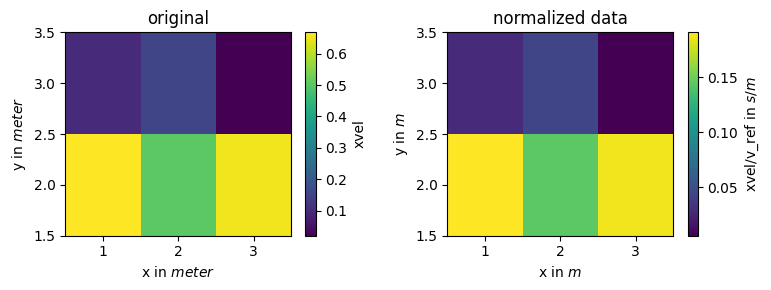

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

vec.xvel.plot(ax=axs[0])
# normalize ALL coordinates:
norm_vec = vec.xvel.normalize(v_ref='3.5 m/s', rename=True)
norm_vec.plot(ax=axs[1])

axs[0].set_title('original')
axs[1].set_title('normalized data')

plt.tight_layout()
plt.show()

### 3.1 Normalize coordinates

Now, let's normalize the coordinates with `L=100 mm`:

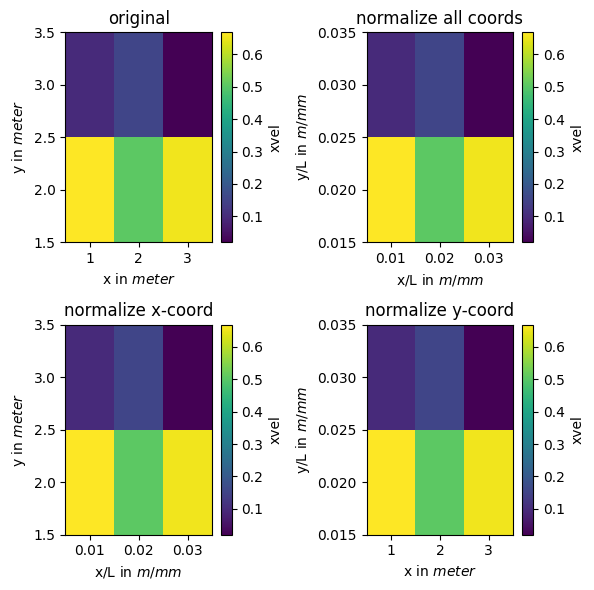

In [8]:
fig, _axs = plt.subplots(2, 2, figsize=(6, 6),
                        tight_layout=True)
axs = _axs.ravel()

vec.xvel.plot(ax=axs[0])

norm_vec = vec.xvel.normalize.coords(L='100 mm', rename=True)  # no units!
norm_vec.plot(ax=axs[1])

norm_vec = vec.xvel.normalize.coords(x={'L': '100 mm'}, rename=True)
norm_vec.plot(ax=axs[2])

norm_vec = vec.xvel.normalize.coords(y={'L': '100 mm'}, rename=True)
norm_vec.plot(ax=axs[3])

axs[0].set_title('original')
axs[1].set_title('normalize all coords')
axs[2].set_title('normalize x-coord')
axs[3].set_title('normalize y-coord')
# for ax in axs:
#     ax.set_aspect(1)

plt.tight_layout()
plt.show()

### Registration of standard attributes
During runtime, we can define so-called "standard attributes" and assign them to group or dataset classes. A more detailed explanation can be found [here](../conventions/standard_attributes_and_conventions.ipynb).

In the following example, the standard attribute shall write user information to attributes. For this, the name and the ORCID is expected. The new standard attribute shall be assigned to the `Dataset` class of the current wrapper:

In [9]:
from h5rdmtoolbox.conventions import StandardAttribute

In [10]:
class UserName(StandardAttribute):
    def set(self, username):
        # username shall be something like ['Max', '0000-1111-2222-3333']
        assert len(username) == 2
        super().set(name='user_name', value=user_name_data[0])
        super().set(name='user_orcid', value=user_name_data[1])
        
    def get(self):
        return super().get('user_name'), super().get('user_orcid')

Let's check if it worked out:

In [11]:
with h5tbx.File() as h5:
    ds = h5.create_dataset('test', shape=(2,))    
    ds.username = 'First User', '0000-0001-8729-0482'
    print(ds.username)
    try:
        ds.username = 'Second User'
    except ValueError as e :
        print(f'Could not add user due to: {e}')
    print(ds.username)
    h5.dump()

('First User', '0000-0001-8729-0482')
Second User


### Registration of datasets
We can also "register" dataset accessory. In the following example, we add "device" as a "property with methods". So "device" seems to be a property which has a method "add". Such an implementation facilitates the interaction with HDF data, too. Note, that this "property-like" accessory is available for all `Dataset` objects from now on in this session:

In [12]:
from h5rdmtoolbox.wrapper.accessory import register_special_dataset
@register_special_dataset('device', h5tbx.Dataset, overwrite=True)
class DeviceProperty:
    """Device Accessor class"""

    def __init__(self, ds):
        self._ds = ds
        self._device_name = 'NoDeviceName'
        
    def add(self, new_device_name):
        """adds the attribute device_name to the dataset"""
        self._ds.attrs['device_name'] = new_device_name
        
    @property
    def name(self):
        return self._ds.attrs['device_name']

In [13]:
with h5tbx.File() as h5:
    ds = h5.create_dataset('test', shape=(2,))
    print(type(ds))
    ds.device.add('my device')
    print(ds.device.name)

<class 'h5rdmtoolbox.wrapper.core.Dataset'>
my device
